# Importing Libraries:

In [1]:
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.callbacks import Callback , ReduceLROnPlateau , ModelCheckpoint, CSVLogger
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow.keras.losses import categorical_crossentropy as logloss
from tensorflow.keras.metrics import categorical_accuracy
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from PIL import Image
import scipy
import tensorflow as tf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import json

# Reading Data:

In [2]:
base_path = '/kaggle/input/deepfake-dataset-merged/'

In [3]:
def plot_img(base_path, set_):
    dir_ = os.path.join(base_path, 'train', set_)
    k = 0
    fig, ax = plt.subplots(3,3, figsize=(10,10))
    fig.suptitle(set_ + 'Faces')
    for j in range(3):
        for i in range(3):
            img = load_img(os.path.join(dir_, os.listdir(os.path.join(dir_))[k]))          
            ax[j,i].imshow(img)
            ax[j,i].set_title("")
            ax[j,i].axis('off')
            k +=1
  #  fig.tight_layout()
    plt.suptitle(set_ + ' Faces')
    return plt

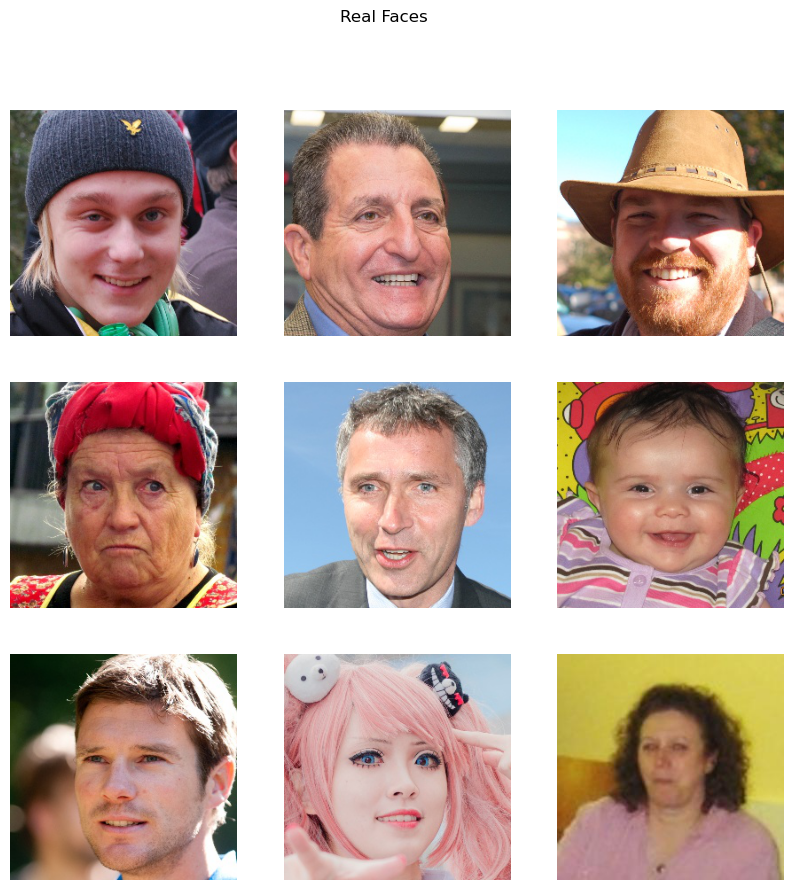

In [4]:
plot_img(base_path, 'Real').show()

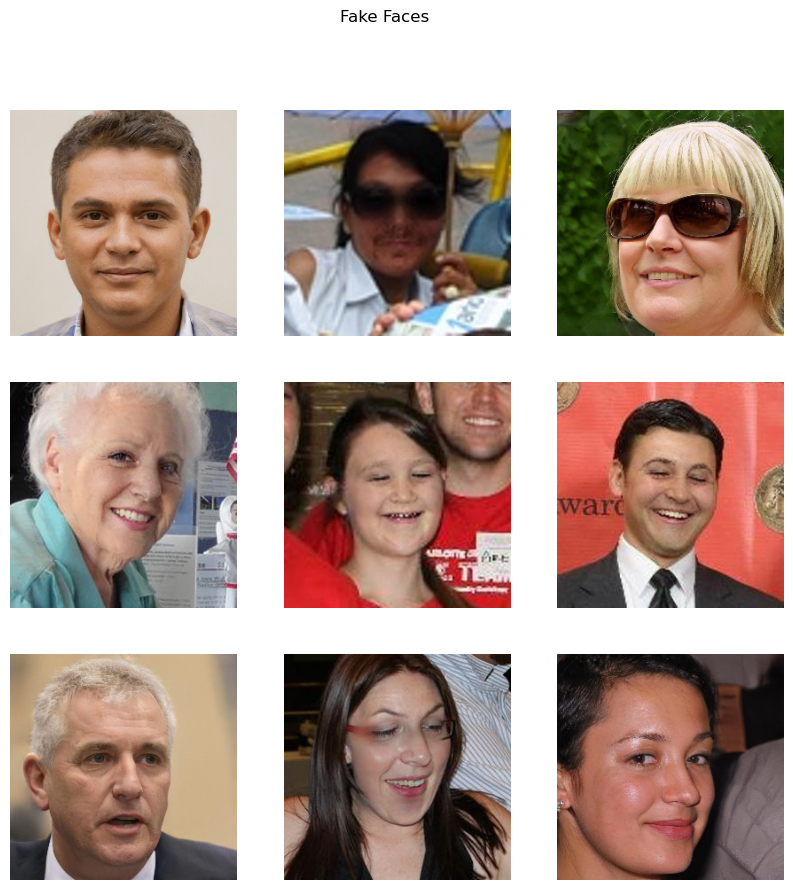

In [5]:
plot_img(base_path, 'Fake').show()

In [6]:
ig = ImageDataGenerator(rescale=1./255.)
train_flow = ig.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

ig1 = ImageDataGenerator(rescale=1./255.)

valid_flow = ig1.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_flow = ig.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    shuffle = False,
    class_mode='categorical'
)

train_flow.class_indices

Found 248002 images belonging to 2 classes.
Found 60428 images belonging to 2 classes.
Found 31905 images belonging to 2 classes.


{'Fake': 0, 'Real': 1}

# Creating Model, ResNet-50 :

In [7]:
def build_model():
    densenet = ResNet50(
                        weights='imagenet',
                        include_top=False,
                        input_shape=(128,128,3)
                        )
    model = Sequential([densenet,
                        layers.GlobalAveragePooling2D(),
                        layers.Dense(512,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dense(2, activation='softmax')
                        ])
    model.compile(optimizer=Adam(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
                 )
    return model

In [8]:
model=build_model()
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                         

In [9]:
checkpoint = ModelCheckpoint(filepath='model.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.0001
                             )
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

# Training the Model:

In [10]:
train_steps = 100000//64
valid_steps = 20000//64

history = model.fit(train_flow,
    epochs = 10,
    steps_per_epoch =train_steps,
    validation_data =valid_flow,
    validation_steps = valid_steps,
    callbacks=callbacks
)

Epoch 1/10
1562/1562 [==============================] - ETA: 0s - loss: 0.2695 - accuracy: 0.8817
Epoch 1: val_loss improved from inf to 0.60837, saving model to model.h5
1562/1562 [==============================] - 901s 551ms/step - loss: 0.2695 - accuracy: 0.8817 - val_loss: 0.6084 - val_accuracy: 0.7945 - lr: 0.0010
Epoch 2/10
1562/1562 [==============================] - ETA: 0s - loss: 0.1228 - accuracy: 0.9526
Epoch 2: val_loss improved from 0.60837 to 0.36735, saving model to model.h5
1562/1562 [==============================] - 759s 486ms/step - loss: 0.1228 - accuracy: 0.9526 - val_loss: 0.3673 - val_accuracy: 0.8310 - lr: 0.0010
Epoch 3/10
1562/1562 [==============================] - ETA: 0s - loss: 0.0986 - accuracy: 0.9614
Epoch 3: val_loss did not improve from 0.36735
1562/1562 [==============================] - 654s 419ms/step - loss: 0.0986 - accuracy: 0.9614 - val_loss: 0.4278 - val_accuracy: 0.8088 - lr: 0.0010
Epoch 4/10
1562/1562 [==============================] - ETA

# Plotting Accuracy and Loss Graph:


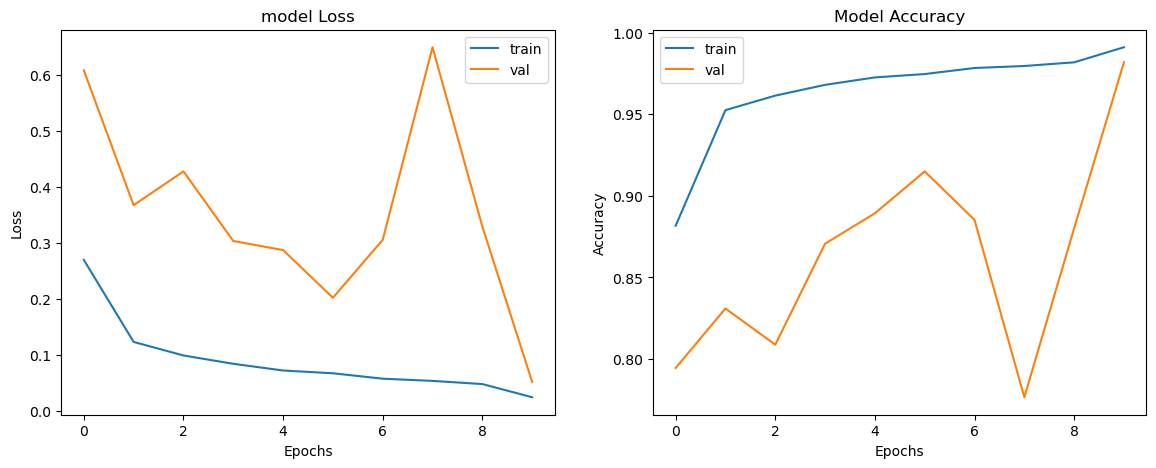

In [11]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

# Confusion Matrix:

In [12]:
y_pred = model.predict(test_flow)

y_test = test_flow.classes

31905/31905 [==============================] - 302s 9ms/step


In [13]:
y_pred_labels = np.argmax(y_pred, axis=1)

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix=confusion_matrix(y_test, y_pred_labels)
confusion_matrix

array([[16248,   244],
       [  965, 14448]])

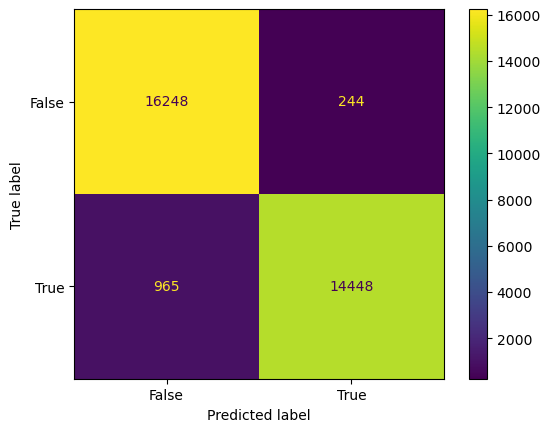

In [15]:
Fake=False
Real=True
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [Fake, Real])

cm_display.plot()
plt.show()

# ROC AUC Score, Precision Score and Test Accuracy:

In [16]:
from sklearn import metrics
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred_labels))
print("AP Score:", metrics.average_precision_score(y_test, y_pred_labels))
print()
print(metrics.classification_report(y_test, y_pred_labels))

ROC AUC Score: 0.9612977311771255
AP Score: 0.9520686779458847

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     16492
           1       0.98      0.94      0.96     15413

    accuracy                           0.96     31905
   macro avg       0.96      0.96      0.96     31905
weighted avg       0.96      0.96      0.96     31905



In [17]:
_, accu = model.evaluate(test_flow)
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

31905/31905 [==============================] - 351s 11ms/step - loss: 0.1151 - accuracy: 0.9621
Final Test Acccuracy = 96.211


# Testing for a random image:

(1, 128, 128, 3)

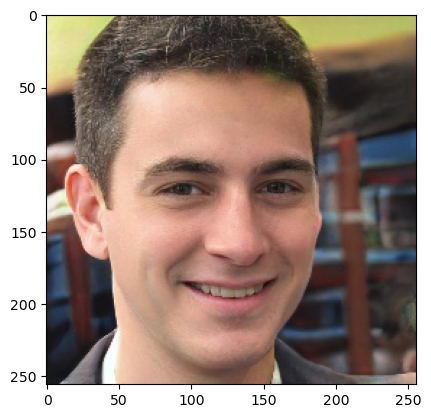

In [18]:
import PIL
from PIL import Image
im1 = Image.open('/kaggle/input/deepfake-dataset-merged/valid/Fake/03W1TOXADG.jpg')
im2=im1.resize((128,128))
p1 = np.array(im2)
p1=p1/255
plt.imshow(im1)
p1 = np.expand_dims(p1, axis=0)
p1.shape

In [19]:
op=np.argmax(model.predict(p1),axis=-1)
print(op)
if op== [0]:
    print('Fake Face')
else:
    print("Real Face")


1/1 [==============================] - 1s 1s/step
[1]
Real Face
